# Participant 3 Adherence Measure 1

Notebook by Jeremy

# Imports

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import statsmodels as st
import statsmodels.api as sm
from scipy import stats
from pandas import DataFrame
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from dateutil.parser import parse
import scipy.stats as scs
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

#Stop warnings
import warnings
warnings.filterwarnings("ignore")


# Read Data

In [24]:
def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d').dt.date
    
    return dat
# 10 hours of non zeroes 
def ten_hours_non_zeros(df,hours):
    df1 = df.copy()
    df1['Not Zero'] = df1['Steps'] > 0
    df1 = df1.groupby('Date').sum()
    df1 = df1['Not Zero'] > hours 
    return df1
#Greater than 500 steps
def greater_than_certain_steps(df,min_steps):
    df1 = df.copy()
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps']> min_steps
    return df1


#Active in 3 time blocks 
def three_time_blocks(df):
    df1 = df.copy()
    bins = [-1,2,10,14,25,np.inf]
    names = ['3','1','2', '4', '5']
    df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names)
    df1 = df1.replace({'3timeblock':r'4'},{'3timeblock':'3'},regex = True)
    df1 = df1.replace({'3timeblock':r'5'},{'3timeblock':'3'},regex = True)
    df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
    df1['Steps within timeblock'] = df1['Steps']> 0 
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps within timeblock'] ==3 
    return df1

#Combining it all into 1 dataframe
def three_method_table(x):
    valid_1= ten_hours_non_zeros(x,10)
    valid_2= greater_than_certain_steps(x,500)
    valid_3= three_time_blocks(x)
    result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
    result.reset_index(level=0, inplace=True)
    result.columns = ["Date", "Ten Hours Non Zero","Steps > Five Hundred","Three Timeblock"]
    result['All Three True'] = result["Three Timeblock"]*result["Ten Hours Non Zero"]*result["Steps > Five Hundred"]
    result_sum = result.sum()
    return result , result_sum

def filter_by_adherence(df, measure):
    df2 = three_method_table(df)[0]
    df3 = df.merge(df2,on ='Date')
    if(measure == 1):
        mask = (df3['Ten Hours Non Zero'] == True)
    elif(measure == 2):
        mask = (df3['Steps > Five Hundred'] == True)
    elif(measure == 3):
        mask = (df3['Three Timeblock'] == True)    
    elif(measure == 4):
        mask = (df3['All Three True'] == True)
    filtered_df = df3.loc[mask].drop(['Ten Hours Non Zero', 'Steps > Five Hundred', 'Three Timeblock', 'All Three True'], axis=1)

    return filtered_df

# Method 1 calculates daily steps based on all the step activity that is available during the day
def all_step_activity(df):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 2 calculates daily steps based on the 10 most active hours of the day
def top_ten_most_active_hours(df):
    
    df = df.sort_values(by=["Date", "Steps"], ascending=False).groupby('Date').head(10)
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 3 calculates daily steps based on a 10 hour time block during the day
def ten_hour_time_block(df, start_hour, end_hour):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    mask = (df['Hour'] >= start_hour) & (df['Hour'] <= end_hour)
    df = df.loc[mask]
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

In [25]:
def modified_calculate_daily_steps(file_name, filter_measure, start_time, end_time):
    
    df = read_CLEAN_data(filename)
    filtered_df = filter_by_adherence(df, filter_measure)
    
    dailysteps_method2 = run_method_2(filtered_df)
    dailysteps_method1 = run_method_1(filtered_df)
    dailysteps_method3 = run_method_3(filtered_df, start_time, end_time)
    
   
    return dailysteps_method1,dailysteps_method2,dailysteps_method3
   

Here, we created a modified version of the calculate_daily_steps() function. However, instead of returning a table containing the date and the various methods of calculating steps, this function returns the steps as values <br />
### Load Data

In [26]:
filename = "../../../data/cleaned/Participant3.csv"

filter_measure = 1
start_time = 8
end_time = 18

ds_method1, ds_method2, ds_method3 = modified_calculate_daily_steps(filename, filter_measure, start_time, end_time)


In the cell above, **filter_measure** can have the value 1, 2, 3 or 4 to select which adherence measure we would like to use. As we have decided that the start and end time be 8am and 6pm daily. The Last line above, creates three (3) values ds_method1, ds_method2 and ds_method3 respective to their methods of counting steps

In [27]:
ds_method1.set_index('Date',inplace=True)
ds_method1.shape

(773, 1)

# Method 1

## Steps to take to implement (S)ARIMA

1) Check for Seasonality <br />
2) Check for Stationarity <br />
3) If not Stationary perform Rolling/ Smoothing/ Shifting/ Differentiation <br />
4) Obtain SARIMA Parameters <br />
5) Data Splitting and Model evaluation by plots <br />
6) Data Forecasting


## All Step Activity (Step Count Method 1)

### 1) Check For Seasonality

##### Simple Plot

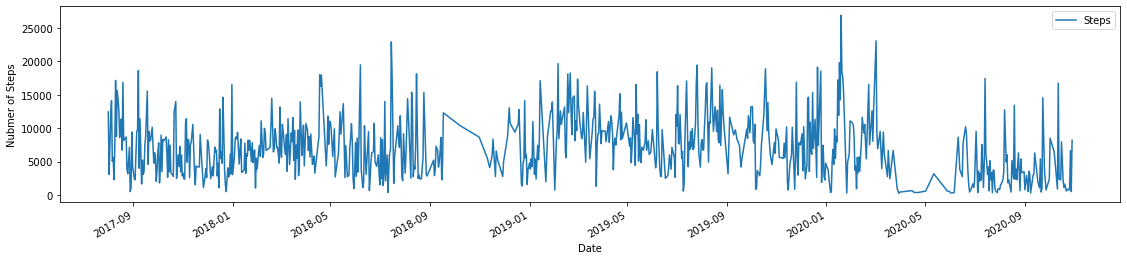

In [9]:
ds_method1.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

It does appear to have some form of seasonality, besides between 2018-09 to 2019-01 and 2020-05 to 2020-09. I suspect this is due to the adherence measure that removed a large portion of the observations during these dates. 

#### Seasonal Decompose Plot

Using the command, we can decompose the time series into three distinct components: Trend, Seasonality and noise

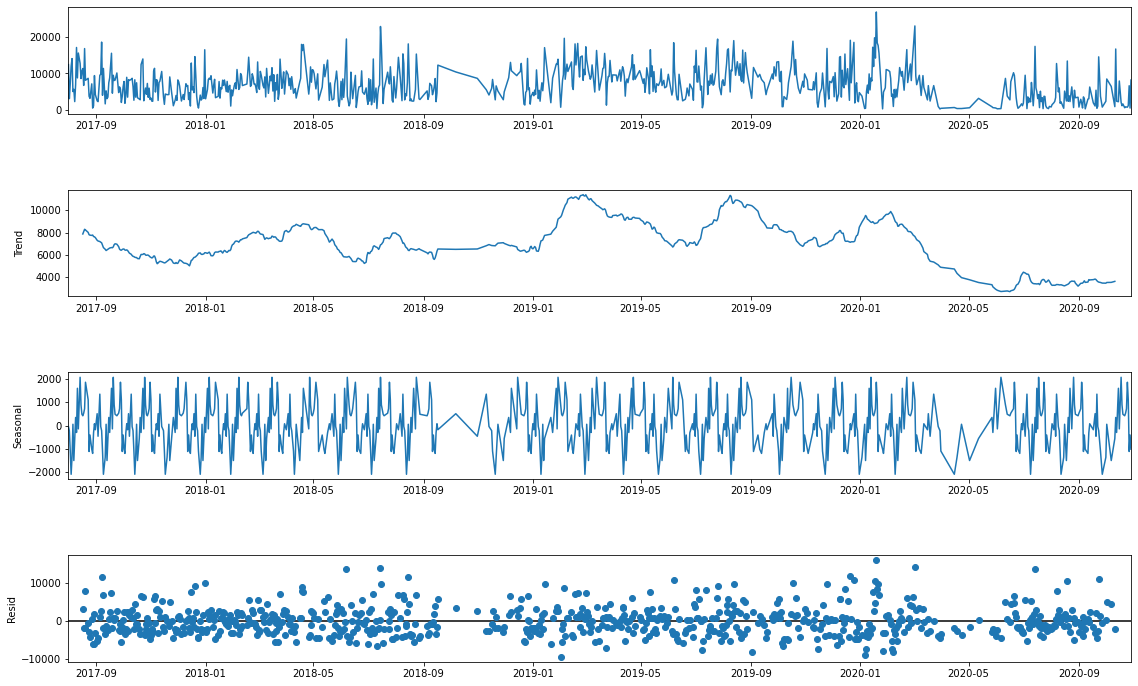

In [7]:
decomposition = sm.tsa.seasonal_decompose(ds_method1, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

After adherence, it appears that the data does have some form of Seasonality over the years besides certain year-gaps. As such, we will employ the SARIMA here instead of ARMIA

# Check for data Stationarity

Will use this function to test for stationarity by using the **Augmented Dickey-Fuller test**

where <br />
$H_0$: If failed to be rejected, time series data is not stationary <br />
$H_1$: If $H_0$ is rejected, it means the time series data is stationary

In [8]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Number of Steps")
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Steps'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

This function produces a graph of the data together with the rolled mean and standard deviation of the data. The **Rolled Mean** and **Rolled Standard Deviation** are the smoothened data making observation of the data across the time series period easier for observation. <br />
In addition to the graph, this function performs the **Augmented Dickey Fuller Test** which allows us to check if the data is stationary (as it is one (1) of the requirements to perform SARIMA.

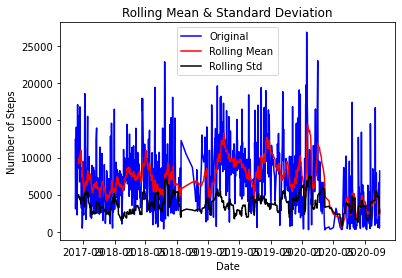

Results of Dickey Fuller Test:
ADF Test Statistic              -5.382365
p-value                          0.000004
#Lags Used                       9.000000
Number of Observations Used    763.000000
Critical Value (1%)             -3.438950
Critical Value (5%)             -2.865335
Critical Value (10%)            -2.568791
dtype: float64


In [9]:
test_stationarity(ds_method1)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 0.000004 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.

## Making Data Stationary

As the data is stationary, we do not need to perform any transformation of the data to achieve stationarity.

# (S)ARIMA Parameters

SARIMA has parameters **(p,d,q)(P,D,Q)[m]** 
The first three (3) are the non-seasonal parameters (p,d,q) 
while the next four (4) are the seasonal parameters (P,D,Q)[m] 
p: The lag order of the model (the number of lags observed in the model 
d: The number of times the data is required to be differentiated to obtain stationarity <br />
q: The size of the moving average window <br />
P: Seasonal Autoregressive Order <br />
D: Seasonal Difference Order <br />
Q: Seasonal Moving Average order <br />
m: the number of steps for a single **seasonal** period

#### ACF and PACF plots

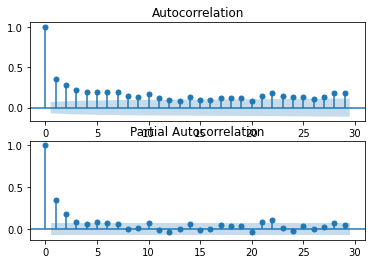

In [11]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method1, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method1, ax=ax[1])
plt.show()

The Partial-Autocorrelation plot is used to select the parameters of p and P we can observe that the ACF plot appears to 'die out' around the 10th lag indicating our estimate of p = 2 <br />
We know that d = 0 as no differentiation was needed to make the data stationary

The Auto-ARIMA Process allows for the selection of the (S)ARIMA parameters more easily

In [15]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method1, start_p=0, start_q=0,
                           max_p=2, max_q=10, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=15195.575, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=15095.726, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=15126.556, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=16159.459, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=15094.490, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=15095.676, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=15097.632, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=15070.081, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=15072.071, Time=0.28 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=15072.067, Time=0.15 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=15069.863, Time=0.09 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=15071.748, Time=0.34 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=15071.863, Time=0.20 sec
 ARIMA(2,0,

So, the best set of paramters to select is  **ARIMA(2,0,1)(1,0,0)[12]** I selected m = 12 to represent the yearly number of months each 'season' runs for 

### ACF and PACF Residuals

Optimization terminated successfully.
         Current function value: 9.732948
         Iterations: 7
         Function evaluations: 408


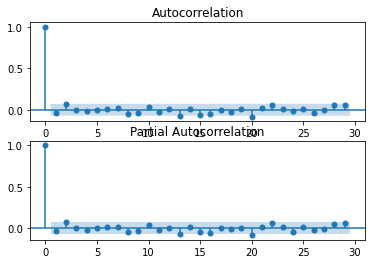

In [16]:
model = sm.tsa.statespace.SARIMAX(ds_method1, order=(2,0,1), seasonal_order = (1,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

From here, we observed that there does not appear to be any signs of autocorrelation so we will continue 

### Data Splitting & Model Evaluation

In [17]:
train = ds_method1.loc['2017-08-01':'2020-01-18']
test = ds_method1.loc['2020-01-19':]
stepwise_model.fit(train)

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

### Model Summary

In [18]:
mod = sm.tsa.statespace.SARIMAX(ds_method1,
                                order=(2, 0, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Steps   No. Observations:                  773
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 12)   Log Likelihood               -7385.353
Date:                             Sun, 15 Nov 2020   AIC                          14780.706
Time:                                     00:12:16   BIC                          14803.866
Sample:                                          0   HQIC                         14789.625
                                             - 773                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1825      0.044     26.884      0.000       1.096       1.269
ar.L2         -0.1840      

Some of the statistical values of the model can be observed form above. The SARIMA model with parameters (2, 0, 1)(1, 0, 0)[12] was fitted and the summary above. It obtained an AIC of 14780.706. As the AIC is reletively high, we can note that the model isn't too accurate

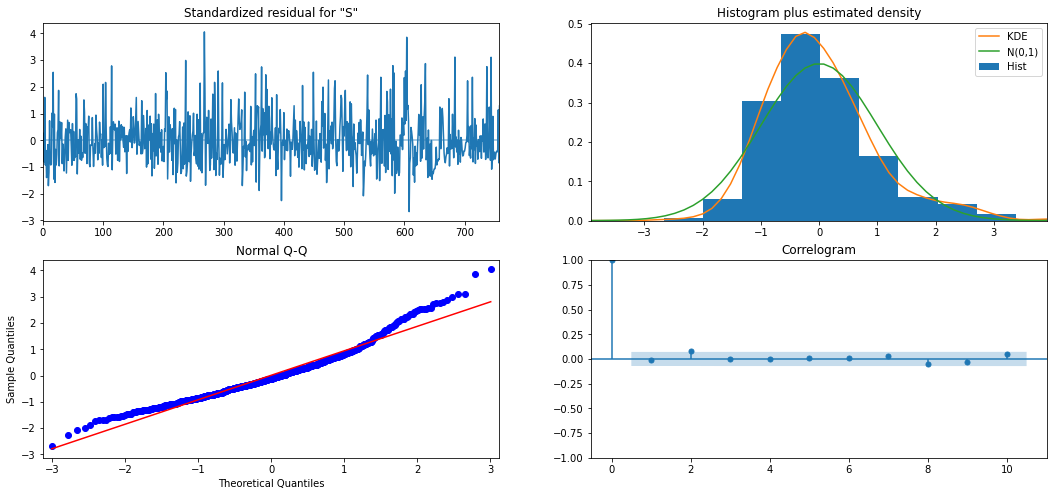

In [19]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

Distribution of the data appears normal, No indication of autocorrelation and the Q-Q plot pints are quite close to the normal. A log transformation might fix this.

### (S)ARIMA Model Validation

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 
# the 20% point test data is on the specified date below
split_date = '2020-01-18'
data = ds_method1['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 0, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

The statistical values are as below

In [23]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae1 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse1 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse1 = math.sqrt(mse1)
print(f'Mean Squared Error: {mse1.round(4)}')
print(f'Root Mean Squared Error: {round(rmse1,4)}')
print(f'Mean Absolute Error: {mae1.round(4)}')

Mean Squared Error: 34135336.1564
Root Mean Squared Error: 5842.5453
Mean Absolute Error: 5143.2371


### Model Prediction

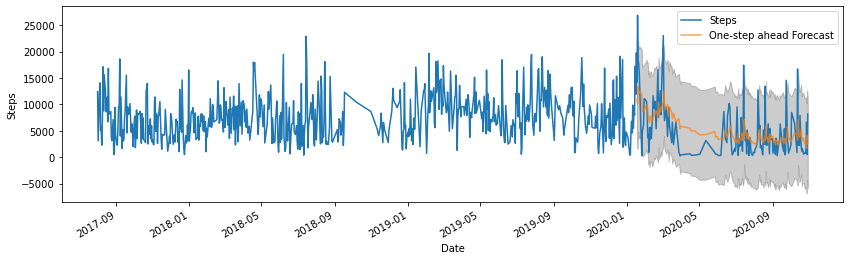

In [24]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-18'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method1['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

Model does not perform very well around 2020-05. Might be due to the adherence measure that removed quite a lot of user data during this time period

# Top Ten Most Active Hours (Step Count Method 2)

In [25]:
#method_1.set_index('Date',inplace=True)
ds_method2.set_index('Date',inplace=True)
ds_method2.head()

,Steps
Date,
2017-08-01,12335.158512
2017-08-02,3063.008540
2017-08-03,7027.358587
2017-08-04,11413.129441
2017-08-05,13821.415285


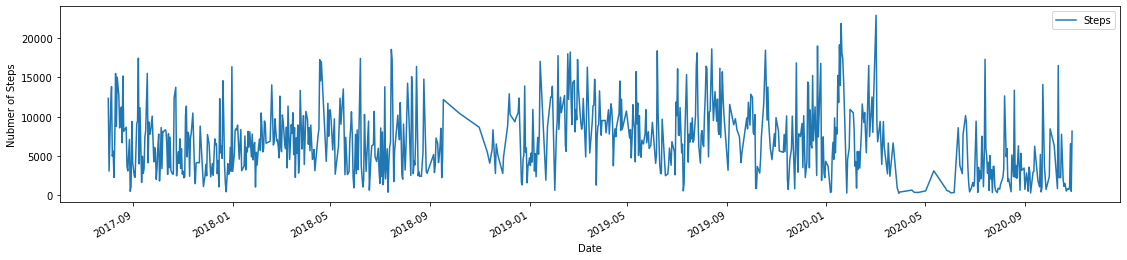

In [26]:
ds_method2.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

The chart does appear to have some form of seasonality besides from 2018-09 to 2019-01 and 2020-05 and 2020-09 where there does not appear to be any data. Similar to earlier, this is due to the adherence measure employed.

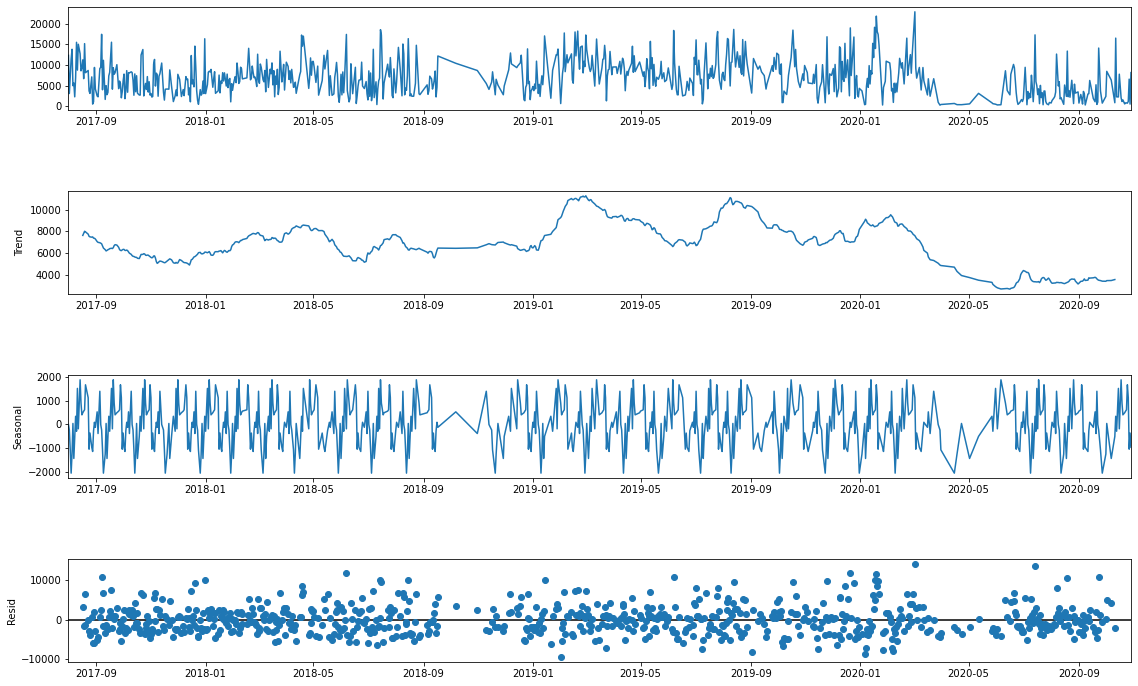

In [27]:
decomposition = sm.tsa.seasonal_decompose(ds_method2, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

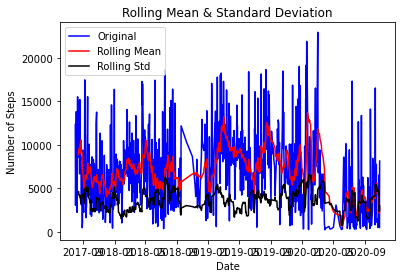

Results of Dickey Fuller Test:
ADF Test Statistic              -5.272064
p-value                          0.000006
#Lags Used                       9.000000
Number of Observations Used    763.000000
Critical Value (1%)             -3.438950
Critical Value (5%)             -2.865335
Critical Value (10%)            -2.568791
dtype: float64


In [28]:
test_stationarity(ds_method2)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 0.000006 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.

## Data Transformation 
As we have concluded that the data is stationary, no data transformation was required

## Obtain SARIMA Parameters

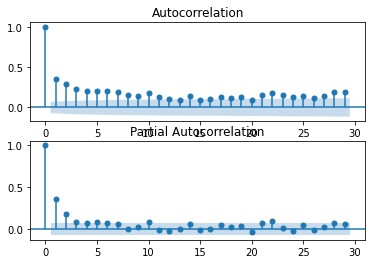

In [30]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method2, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method2,ax=ax[1])
plt.show()

Like earlier, the PACF graph is used to determine the estimated p value which appears to be 2 in this case. While the q value is usually estimated to be around the same value as p. The d = 0 as no differenciation was required.

In [33]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method2, start_p=0, start_q=0,
                           max_p=2, max_q=2, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=15142.217, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=15038.891, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=15070.711, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=16120.545, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=15037.833, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=15038.827, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=15040.773, Time=0.52 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=15013.101, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=15015.100, Time=0.27 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=15015.098, Time=0.15 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=15017.096, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=15012.748, Time=0.09 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=15014.666, Time=0.29 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=15014.746, Time=0.21 sec
 ARIM

### Residuals of ACF and PACF

Optimization terminated successfully.
         Current function value: 9.695049
         Iterations: 4
         Function evaluations: 192


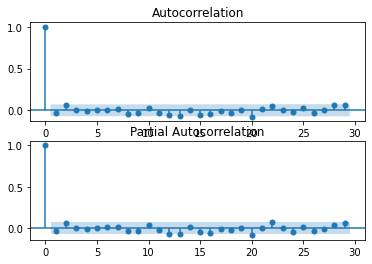

In [35]:
model = sm.tsa.statespace.SARIMAX(ds_method2, order=(2,0,1), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res,  ax=ax[1])
plt.show()

Appears that Autocorrelation is not an issue by selecting these parameters

### Data Splitting and Model Evaluation

In [36]:
train = ds_method2.loc['2017-08-01':'2020-01-18']
test = ds_method2.loc['2020-01-19':]
stepwise_model.fit(train)

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In the cell above, I fitted the model based on those dates. I set the train data to be 80% of the total data and test data to be 20% of the entire data before fitting the train data in a stepwise model.

In [37]:
mod = sm.tsa.statespace.SARIMAX(ds_method2,
                                order=(2,0,1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                  773
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -7476.965
Date:                Sun, 15 Nov 2020   AIC                          14961.929
Time:                        00:14:39   BIC                          14980.520
Sample:                             0   HQIC                         14969.083
                                - 773                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1661      0.042     27.670      0.000       1.084       1.249
ar.L2         -0.1684      0.042     -3.988      0.000      -0.251      -0.086
ma.L1         -0.9137      0.017    -52.971      0.0

The SARIMA(2,0,1)(0, 0, 0)[12] model summary above with an AIC of 14961.929

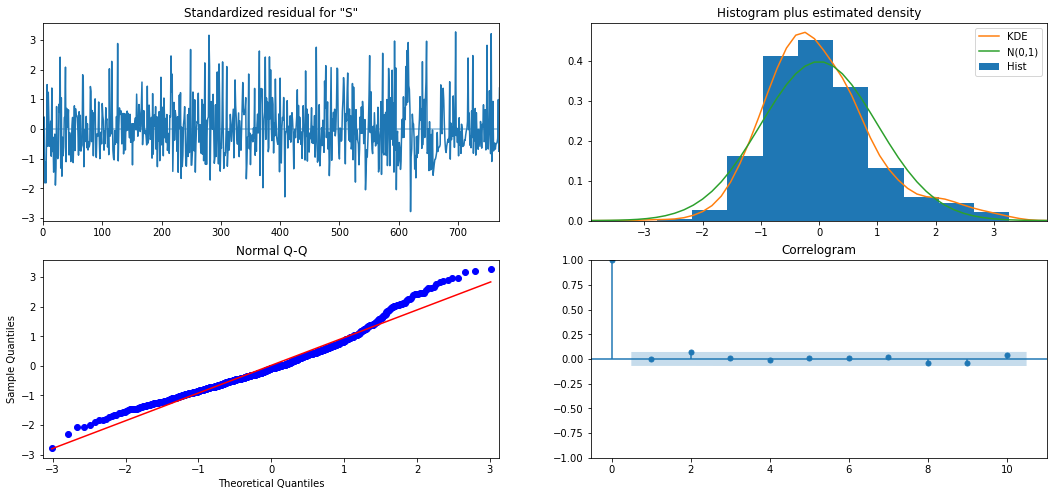

In [38]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

Some plots. We can observe that the data observes a reletively normal distribution, no Autocorrelation is observed, The points on the Q-Q plot are close to the line indicating a good fit

# Model Validation

In [39]:
# the 20% point test data is on the specified date below
split_date = '2020-01-18'
data = ds_method2['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(2,0, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

Above cell shows the model being fitted in order to obtain the statistical values below

In [40]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae2 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse2 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse2 = math.sqrt(mse2)
print(f'Mean Squared Error: {mse2.round(4)}')
print(f'Root Mean Squared Error: {round(rmse2,4)}')
print(f'Mean Absolute Error: {mae2.round(4)}')

Mean Squared Error: 29781709.642
Root Mean Squared Error: 5457.2621
Mean Absolute Error: 4808.6521


### Model Prediction

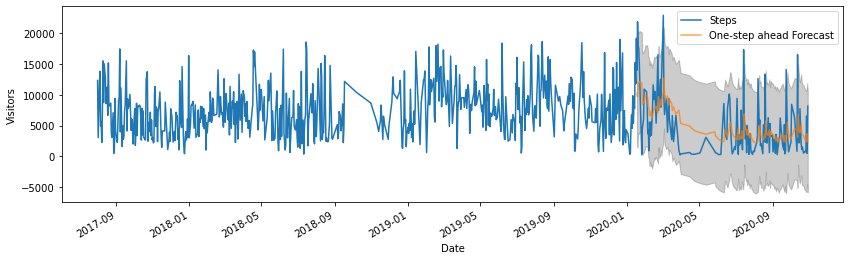

In [41]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-18'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method2['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()
plt.show()

The prediction isnt very good around the 2020-05 area. This could be due to the removed data chunks removing information that would allow the model to train.

# Method 3

Details are Same as above 2

In [42]:
#method_1.set_index('Date',inplace=True)
ds_method3.set_index('Date',inplace=True)

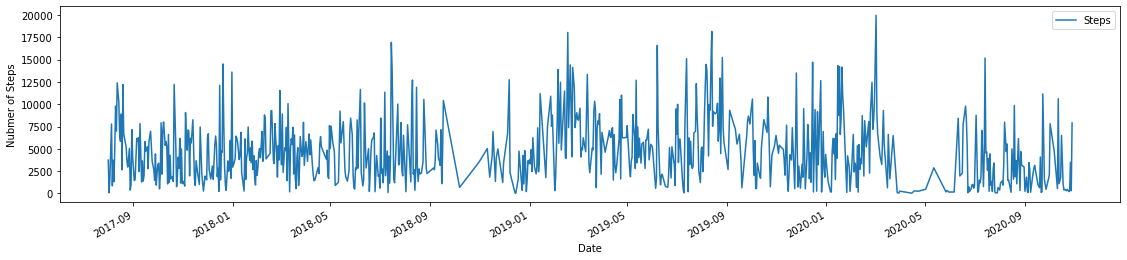

In [43]:
ds_method3.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

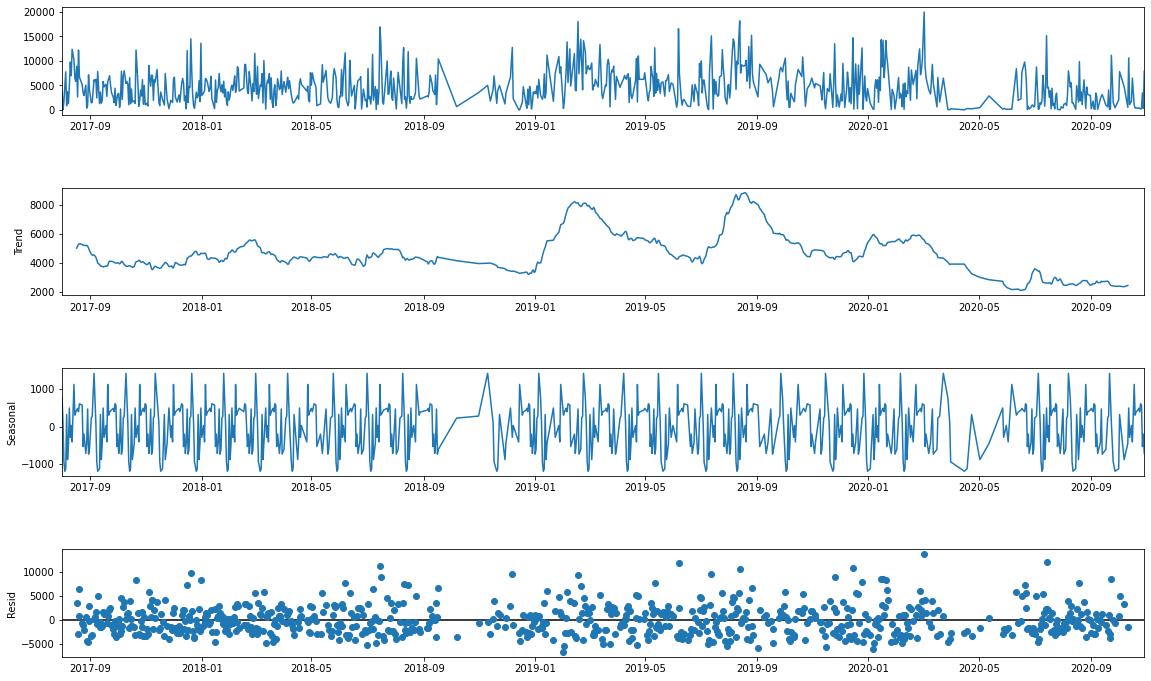

In [44]:
decomposition = sm.tsa.seasonal_decompose(ds_method3, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

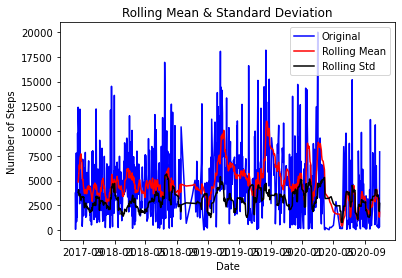

Results of Dickey Fuller Test:
ADF Test Statistic            -6.792812e+00
p-value                        2.341232e-09
#Lags Used                     6.000000e+00
Number of Observations Used    7.660000e+02
Critical Value (1%)           -3.438916e+00
Critical Value (5%)           -2.865321e+00
Critical Value (10%)          -2.568783e+00
dtype: float64


In [45]:
test_stationarity(ds_method3)

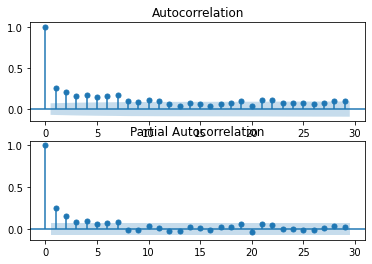

In [47]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method3,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method3,  ax=ax[1])
plt.show()

In [56]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method3, start_p=0, start_q=0,
                           max_p=7, max_q=10, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=14829.888, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=14782.183, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=14794.966, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=15607.964, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=14780.671, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=14782.091, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=14784.079, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=14764.287, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=14766.234, Time=0.26 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=14766.225, Time=0.17 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=14768.225, Time=0.56 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=14760.260, Time=0.06 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=14762.243, Time=0.34 sec
 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=14762.237, Time=0.18 sec
 ARIM

Optimization terminated successfully.
         Current function value: 9.554514
         Iterations: 1
         Function evaluations: 97


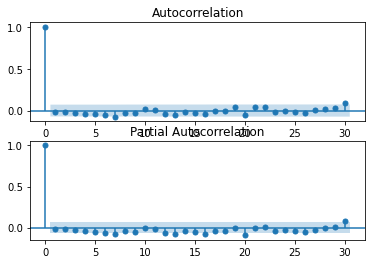

In [57]:
model = sm.tsa.statespace.SARIMAX(ds_method3, order=(7,0,0), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [58]:
train = ds_method3.loc['2017-08-01':'2020-01-18']
test = ds_method3.loc['2020-01-19':]
stepwise_model.fit(train)

ARIMA(order=(7, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [59]:
mod = sm.tsa.statespace.SARIMAX(ds_method3,
                                order=(7,0,0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                  773
Model:               SARIMAX(7, 0, 0)   Log Likelihood               -7319.043
Date:                Sun, 15 Nov 2020   AIC                          14654.086
Time:                        00:17:16   BIC                          14691.215
Sample:                             0   HQIC                         14668.379
                                - 773                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2308      0.034      6.750      0.000       0.164       0.298
ar.L2          0.1590      0.036      4.471      0.000       0.089       0.229
ar.L3          0.0975      0.037      2.637      0.0

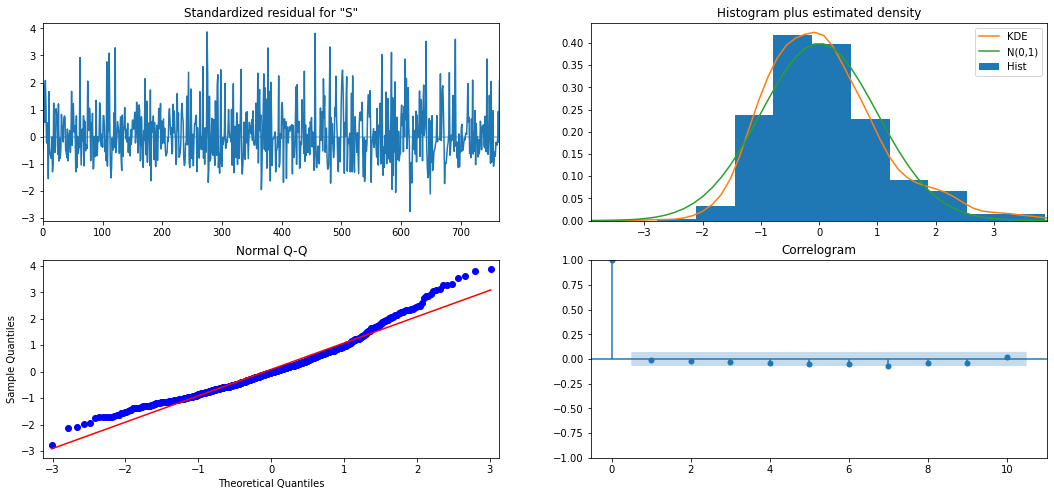

In [60]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

### Model Validation

In [61]:
# the 20% point test data is on the specified date below
split_date = '2020-01-18'
data = ds_method3['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(7,0,0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [62]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae3 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse3 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse3 = math.sqrt(mse3)
print(f'Mean Squared Error: {mse3.round(4)}')
print(f'Root Mean Squared Error: {round(rmse3,4)}')
print(f'Mean Absolute Error: {mae3.round(4)}')

Mean Squared Error: 13044691.4549
Root Mean Squared Error: 3611.7435
Mean Absolute Error: 2824.8351


### Model Prediction

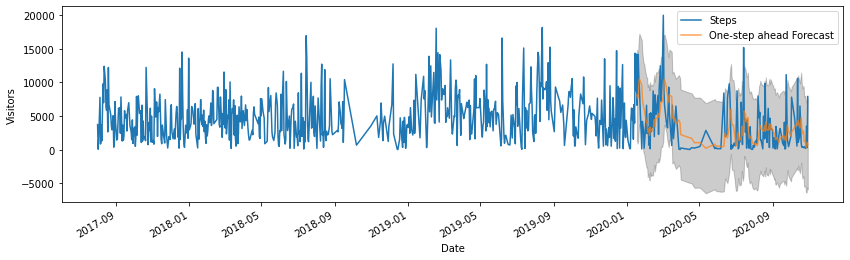

In [63]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-18'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method3['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()
plt.show()

### Comparing All three (3) Step Count Methods

In [64]:
models = pd.DataFrame({
    'Method': ['Method 1', 'Method 2', 'Method 3'],
    'MSE': [round(mse1, 4), round(mse2, 4), round(mse3,4)],
    'RMSE': [round(rmse1,4 ), round(rmse2, 4), round(rmse3,4)],
    'MAE': [round(mae1, 4), round(mae2, 4), round(mae3,4)]})
models

,Method,MSE,RMSE,MAE
0,Method 1,3.413534e+07,5842.5453,5143.2371
1,Method 2,2.978171e+07,5457.2621,4808.6521
2,Method 3,1.304469e+07,3611.7435,2824.8351


Based on the above predictions, we can observe that **Method 3** had the best prediction and the **RMSE** value of **Model 3** is the lowest, therefore, we can conclude that the **Method 3** performs the best here.